In [1]:

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import matplotlib.cm as cm
from scipy import fftpack, ndimage
import cv2 as cv
from os import listdir
from os.path import isfile, join
from skimage.morphology import skeletonize
import math
%matplotlib inline


# Creation automatique des ROI

In [30]:
onlyfiles = [f for f in listdir("im0rasant") if isfile(join("im0rasant", f))]
for path in onlyfiles:
    img = cv.imread("im0rasant/" + path)
    img = np.array(img)
    mask = img[:,:,1]<130
    mask=mask*1
    kernel = np.ones((30,30),np.uint8)
    mask = cv.morphologyEx(mask.astype('uint8'),cv.MORPH_CLOSE, kernel)
    com = ndimage.center_of_mass(mask)
    #roi = img[int(com[0]-180):int(com[0]+220),int(com[1]-460):int(com[1]-60)] # pour 90degres
    roi = img[int(com[0]-500):int(com[0]-100),int(com[1]-200):int(com[1]+200)] # pour 0degres
    cv.imwrite("rois/" + path, roi) 

# Creation des transformées de fourier

In [33]:
onlyfiles = [f for f in listdir("rois") if isfile(join("rois", f))]
avgIndicator = np.zeros(0)
avgy = np.array([])
angleInd = np.array([])
for path in onlyfiles:
    avgy= np.append(avgy, int(path.split("_")[0][1:]))
    angleInd = np.append(angleInd,int(path.split("_")[1]))
    roi = cv.imread("rois/" + path,0)
    roi = np.array(roi).astype('uint8')
    fft2 = fftpack.fft2(roi)
    # on mets les basses fréquences à 0 (elles correspondent au gradient de luminosité ainsi qu’a la luminance)
    zeroRadius = 7
    fft2[0:zeroRadius,0:zeroRadius]=np.zeros((zeroRadius,zeroRadius))
    fft2[-(zeroRadius-1):,0:zeroRadius]=np.zeros((zeroRadius-1,zeroRadius))
    fft2[0:zeroRadius,-(zeroRadius-1):]=np.zeros((zeroRadius,zeroRadius-1))
    fft2[-(zeroRadius-1):,-(zeroRadius-1):]=np.zeros((zeroRadius-1,zeroRadius-1))
    fft2 = fftpack.fftshift(fft2)

    fourierOut = np.absolute(fft2)
    afffourierOut = np.interp(fourierOut, (fourierOut.min(),fourierOut.max()),(0,255)) # Affichage de fourier
    afffourierOut = afffourierOut[100:-100,100:-100] # Les très hautes fréquences ne sont pas intéressantes dans notre cas (sinon la résolution de l’acquisition est à augmenter)
    fourierOut = fourierOut[100:-100,100:-100] 
    ijmax = np.unravel_index(np.argmax(fft2),fft2.shape)
    nroi = cv.resize(roi, afffourierOut.shape)
    if angleInd[-1] == 0:
        fourierOut = cv.rotate(fourierOut,cv.ROTATE_90_CLOCKWISE)
        afffourierOut = cv.rotate(afffourierOut,cv.ROTATE_90_CLOCKWISE)
        nroi = cv.rotate(nroi,cv.ROTATE_90_CLOCKWISE)
    afffourierOut = cv.rectangle(afffourierOut, (90,46), (107,71), (255,0,0), 1)
    ind, fourierOut = cv.threshold(fourierOut, 20000, 255, cv.THRESH_TOZERO)
    Textsum = np.sum(fourierOut[46:71,90:107])
    avgIndicator = np.append(avgIndicator,Textsum)
    afffourierOut = np.hstack(np.array([afffourierOut, nroi]))
    # On agrandi l’image pour la visualisation
    width = int(afffourierOut.shape[1] * 2)
    height = int(afffourierOut.shape[0] * 2)
    dim = (width, height)
    afffourierOut = cv.resize(afffourierOut, dim)
    cv.imwrite("Fourrier/" + path.split(".")[0] + ".png", afffourierOut)




### Ajout de notre indice sur les images

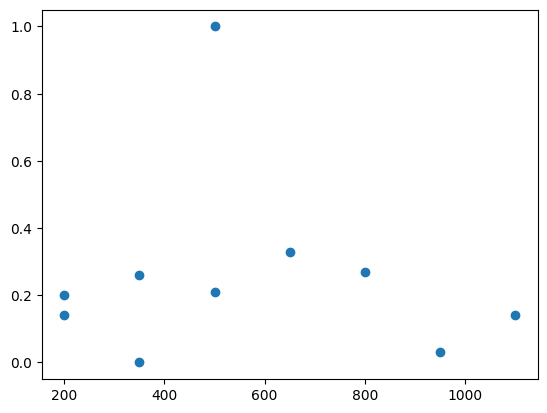

In [34]:

avgIndicator = np.round(np.interp(avgIndicator, (avgIndicator.min(),avgIndicator.max()),(0,1)),2)


# font
font = cv.FONT_HERSHEY_SIMPLEX
  
# org
org = (50, 50)
  
# fontScale
fontScale = 0.5
   
# Blue color in BGR
color = (255, 0, 0)
  
# Line thickness of 2 px
thickness = int(1)

res = [[],[]]
for i,path in enumerate(onlyfiles):
    fourierIn = cv.imread("Fourrier/" + path,0)
    fourierOut = cv.putText(fourierIn,str(avgIndicator[i]) , org, font, 
                    fontScale, color, thickness, cv.LINE_AA)
    cv.imwrite("Fourrier/" + path, fourierOut)
for i in range(len(avgIndicator)):
    if angleInd[i]==0:
        res[0].append(avgIndicator[i])
        res[1].append(avgy[i])
#print(res)
plt.scatter(res[1], res[0])

[178 180 182 ... 163 161 161]


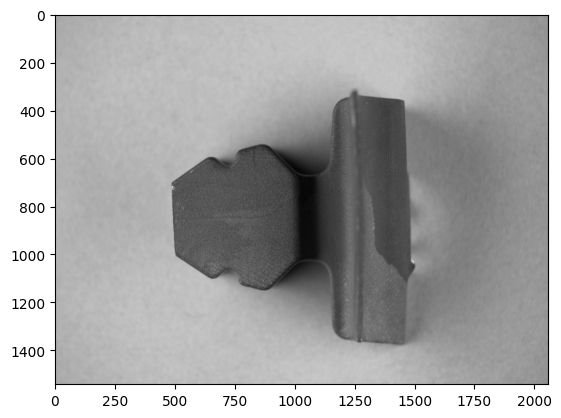

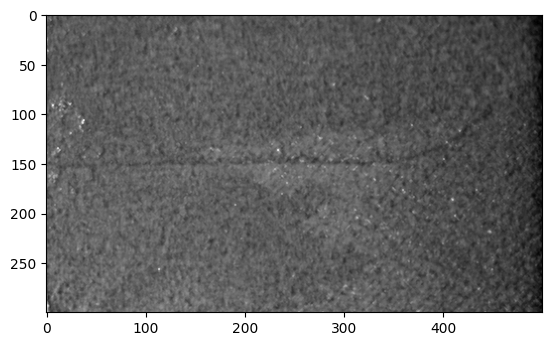

In [7]:

img = Image.open("Images_PRI/Q350_90_pi.png").convert("L")
img = np.array(img)
roi = img[700:1000,500:1000]
print(img[0])
plt.figure()
plt.imshow(img, cmap=cm.gray)
plt.figure()
plt.imshow(roi, cmap=cm.gray)

(152, 250)


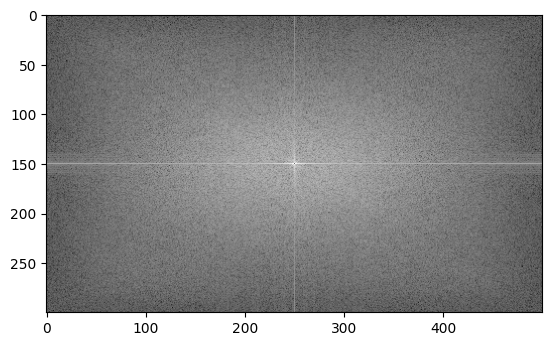

In [8]:
fft2 = fftpack.fft2(roi)
fft2[0][0]=0
fft2 = fftpack.fftshift(fft2)
#Z = fftn(img)
#print(np.real(Z)[0])
plt.imshow(np.absolute(fft2),cmap=cm.gray, norm="log")
print(np.unravel_index(np.argmax(fft2),fft2.shape))

In [70]:
import matplotlib


['asinh', 'function', 'functionlog', 'linear', 'log', 'logit', 'symlog']